In [46]:
import numpy as np
import matplotlib.pyplot as plt
import yasa
import pandas as pd
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch
from sklearn.metrics import accuracy_score

In [47]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

### データの用意

In [48]:
[alice_files] = fetch_data(subjects=[0], recording=[1])

edf = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker',
                                misc=['Temp rectal'])

annot = mne.read_annotations(alice_files[1])

annot.crop(annot[1]['onset'] - 30 * 60,
                annot[-2]['onset'] + 30 * 60)

edf.set_annotations(annot, emit_warning=False)

events, _ = mne.events_from_annotations(
    edf, event_id=annotation_desc_2_event_id, chunk_duration=30.)

tmax = 30. - 1. / edf.info['sfreq']

epochs = mne.Epochs(raw=edf, events=events, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

# 1次元配列の抽出
hypno = epochs.events[:, 2] - 1


edf.crop(tmin=float(annot[1]['onset'] - 30 * 60), tmax=float(annot[-2]['onset'] + 40 * 60))

csv = pd.DataFrame(hypno)
csv.to_csv("./1.csv")



Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated


In [49]:
ch = edf.ch_names
print(ch)
i = 0
for data in ch:
    if "EEG" in data:
        EEG = i
    elif "EOG" in data:
        EOG = i
    elif "EMG" in data:
        EMG = i
    i += 1

print(EEG)
print(EOG)
print(EMG)


['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
1
2
4


### a

In [50]:
sls = yasa.SleepStaging(edf, eeg_name="EEG Fpz-Cz", eog_name="EOG horizontal", emg_name="EMG submental")
hypno_pred = sls.predict()
hypno_pred = yasa.hypno_str_to_int(hypno_pred)

csv_pre = pd.DataFrame(hypno_pred)
csv_pre.to_csv("./2.csv")

### 特徴量

In [51]:
model = sls._load_model("auto")
print(model.feature_name_)

['eeg_abspow', 'eeg_abspow_c7min_norm', 'eeg_abspow_p2min_norm', 'eeg_alpha', 'eeg_alpha_c7min_norm', 'eeg_alpha_p2min_norm', 'eeg_at', 'eeg_at_c7min_norm', 'eeg_at_p2min_norm', 'eeg_beta', 'eeg_beta_c7min_norm', 'eeg_beta_p2min_norm', 'eeg_db', 'eeg_db_c7min_norm', 'eeg_db_p2min_norm', 'eeg_ds', 'eeg_ds_c7min_norm', 'eeg_ds_p2min_norm', 'eeg_dt', 'eeg_dt_c7min_norm', 'eeg_dt_p2min_norm', 'eeg_fdelta', 'eeg_fdelta_c7min_norm', 'eeg_fdelta_p2min_norm', 'eeg_hcomp', 'eeg_hcomp_c7min_norm', 'eeg_hcomp_p2min_norm', 'eeg_higuchi', 'eeg_higuchi_c7min_norm', 'eeg_higuchi_p2min_norm', 'eeg_hmob', 'eeg_hmob_c7min_norm', 'eeg_hmob_p2min_norm', 'eeg_iqr', 'eeg_iqr_c7min_norm', 'eeg_iqr_p2min_norm', 'eeg_kurt', 'eeg_kurt_c7min_norm', 'eeg_kurt_p2min_norm', 'eeg_nzc', 'eeg_nzc_c7min_norm', 'eeg_nzc_p2min_norm', 'eeg_perm', 'eeg_perm_c7min_norm', 'eeg_perm_p2min_norm', 'eeg_petrosian', 'eeg_petrosian_c7min_norm', 'eeg_petrosian_p2min_norm', 'eeg_sdelta', 'eeg_sdelta_c7min_norm', 'eeg_sdelta_p2min_no

### 状態遷移の修正

- W→N2, W→N3の状態遷移を取り除く
- W→N2→N3 を W→N1→N2→N3とする

パターン判別用関数

In [52]:
# Pattern 1: 0, x, x, ... x, x, 0 (1 < x < 4)
# Pattern 2: 0, 2, 2, 3, ...
def check_trans(array, index, current, count):
    if index + 1 == array.size:
        return ["NIL", 0]

    stage = array[index + 1]
    
    # 0, 2, 2, ... 2, 0
    if stage == 0:
        return ["Pattern 1", count]

    elif stage != 0 and stage != current:
        # 0, 2, 2, 3, ... 
        if current == 2 and stage == 3:
            return ["Pattern 2", 0]

        return ["NIL", 0]

    # 同じステージだったら、調査位置とカウントを1増やして再帰
    elif stage == current:
        return check_trans(array, index + 1, current, count + 1)

修正用関数

In [53]:
def fix_hypno(array):
    size = array.shape[0]
    res = [False, 0]

    for i in range(size - 1):
        # パターン調査
        if array[i] == 0:
            for j in [2,3]:
                # 0, 0, j, ... の並び
                if array[i + 1] == j:
                    count = 0
                    res = check_trans(array, i, j, count)

        # 修正
        # Pattern 1: 指定範囲を全て0に置換
        if res[0] == "Pattern 1" and res[1] != 0:
            array[i + 1] = 0
            res[1] -= 1
            if res[1] == 0:
                res[0] = "NIL"
        
        # Pattern 2: Pattern 2が始まる直前の0を1に置換
        if res[0] == "Pattern 2":
            array[i] = 1
            res[0] = "NIL"

In [54]:
# hypno_pred = np.array([0,0,0,2,2,0,0,2,3,0])
fixed = np.copy(hypno_pred)

fix_hypno(fixed)

csv_fixed = pd.DataFrame(fixed)
csv_fixed.to_csv("./3.csv")

### ヒプノグラムの表示

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

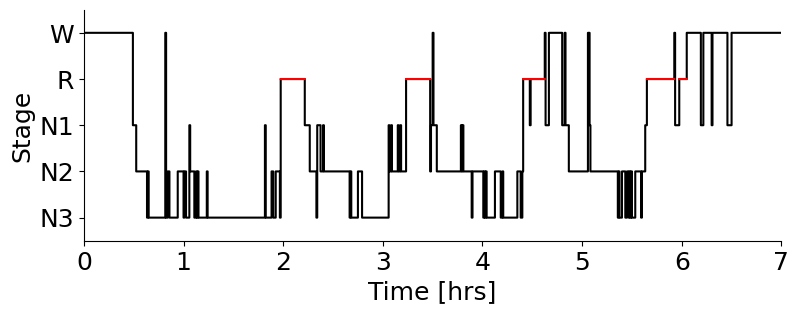

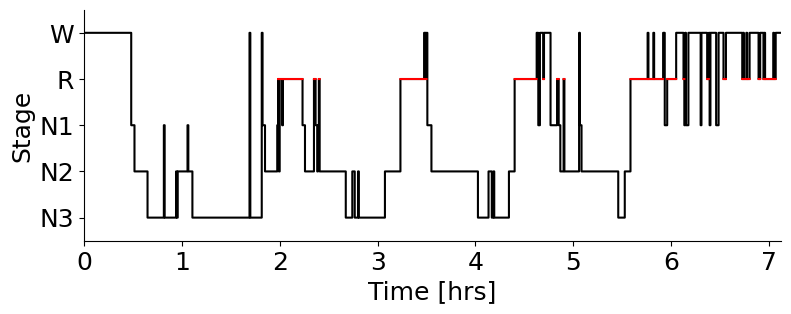

In [55]:
# hypno_pred = np.loadtxt("csv_fixed_hand.csv", delimiter=",")[:, 1]

yasa.plot_hypnogram(hypno)
yasa.plot_hypnogram(hypno_pred)
#yasa.plot_hypnogram(fix_case1)
#yasa.plot_hypnogram(fixed) 
#yasa.plot_hypnogram(fix_case3)

In [56]:
length = -(len(hypno_pred) - len(hypno))
acc_bef = accuracy_score(hypno, hypno_pred[:length]) # 正解率

print('正解率: ', acc_bef) 
#print('  手動修正後', acc_aft)
#print('  修正後(方法1)', acc_case1)

#print('  修正後(方法3)', acc_case3)

正解率:  0.835909631391201
